# Imports and Setup

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from IPython.display import Image
from qutip import (Qobj, about, basis, Bloch, Bloch3d, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, tensor, thermal_dm, sesolve)
from qutip.ipynbtools import plot_animation
from scipy.optimize import curve_fit
%matplotlib notebook
plt.rc('font', size=16)         # Set the default text font size
plt.rc('axes', titlesize=16)    # Set the axes title font size
plt.rc('axes', labelsize=16)    # Set the axes labels font size
plt.rc('xtick', labelsize=16)   # Set the font size for x tick labels
plt.rc('ytick', labelsize=16)   # Set the font size for y tick labels
plt.rc('legend', fontsize=18)   # Set the legend font size
plt.rc('figure', titlesize=20)  # Set the font size of the figure title
plt.rc("text", usetex=False)

#Adjusting the way to write some of the functions because I'm lazy
σx = sigmax
σy = sigmay
σz = sigmaz
I = qeye

# Hamiltonian
We will be using the Hamiltonian for a two level system in an electric field. Generically we write this as:
$$
\mathcal{H} = -(\epsilon + 2\vec{p}\cdot \vec{E}(t)\cos(t\phi) )\hat{S}^Z - 2\vec{p}\cdot \vec{E}(t)\sin (2\phi) \hat{S}^X
$$
Where we have $\epsilon = \sqrt{\Delta^2+\Delta_T^2}$ where $Delta$ is the energy asymmetry of the double well and $\Delta_T$ is the tunnelling probability between the two wells. $\phi$ defines the ratio between the all the energies in that $\tan 2\phi = \Delta_T/\Delta$, $\sin 2\phi = \Delta_T/\epsilon$, and $\cos 2\phi = \Delta/\epsilon$.

We will consider the case where we have two independent oscillating electric fields. This means that $\vec{E}(t)$ is given by $\vec{E}(t) = \vec{E}_1 \cos(\nu_1 t) + \vec{E}_2 \cos (\nu_2 t)$. This means that the full Hamiltonian is given by
$$
\mathcal{H}_2 = -\epsilon \hat{S}^Z - \sum_{i=1,2} 2\hbar \Omega_{Z,i}\cos(\nu_i t) \hat{S}^Z + 2\hbar \Omega_{X,,i}\cos(\nu_i t)\hat{S}^X
$$
where $\Omega_{z,i} = \Omega_0\cos(\theta_i)\cos(2\phi)$, $\Omega_{x.i}=\Omega\cos(\theta_i)\sin(2\phi)$ and $\Omega_0$ is the bare Rabi Frequency. $\theta_i$ is the angle between the electric dipole and the $\vec{E}_i$ field for each of teh two fields. We will consider the case that the $\Omega_{Z/X,1}=\Omega_{Z/X,2}\equiv \Omega_X$ so that we can rewrite the X component of the field to be:
$$
\Omega_{X,1}\cos(\nu_1 t) + \Omega_{X,2}\cos(\nu_2 t) = \Omega_x(\cos(\nu_1 t)+\cos(\nu_2 t)) = 2\Omega_x \cos(\tilde{\nu} t)\cos(\delta\nu t) \equiv \Omega_x(t)
$$
Where we defined $\tilde{\nu}=(\nu_1+\nu_2)/2$ and $\tilde{\nu_2} = (\nu_1-\nu_2)/2$. Then we can ignore the AC Stark term (the $\Omega_{Z,i}$ terms) and we apply the Rotating Wave Approximation we get the final Hamiltonian that we will use:

$$ \mathcal{H}'_2 = -(\epsilon - \hbar\tilde{\nu})\hat{S}^Z -2\hbar\Omega_X\cos(\delta\nu t)\hat{S}^X$$

## Define Hamiltonian

In [2]:
def H2(t: float, args: dict):

    ϵ = args["eps"]
    νp = args["vp"]
    Ωx = args["omegaX"]
    δν = args["dv"]
    return -(ϵ-νp)*Sz - 2*Ωx*np.cos(δν*t)*Sx

## Constants

In [3]:
δν = 0
νp = 5
Ωx = 0.1
ϵ = 5
Sx = σx()/2
Sy = σy()/2
Sz = σz()/2

## First Attempt Just Using the SE Solver

In [4]:
ψ0 = basis(2,0)
times = np.linspace(0,200,200)
result = sesolve(H2,ψ0, times, e_ops=[], args=dict(eps=ϵ, vp=νp, omegaX=Ωx, dv=δν), progress_bar=True)

10.0%. Run time:   0.14s. Est. time left: 00:00:00:01
20.0%. Run time:   0.28s. Est. time left: 00:00:00:01
30.0%. Run time:   0.43s. Est. time left: 00:00:00:00
40.0%. Run time:   0.58s. Est. time left: 00:00:00:00
50.0%. Run time:   0.73s. Est. time left: 00:00:00:00
60.0%. Run time:   0.88s. Est. time left: 00:00:00:00
70.0%. Run time:   1.04s. Est. time left: 00:00:00:00
80.0%. Run time:   1.19s. Est. time left: 00:00:00:00
90.0%. Run time:   1.34s. Est. time left: 00:00:00:00
Total run time:   1.48s


In [6]:
fig, ax = plt.subplots(figsize=(16,9))
probs = np.abs(result.states) ** 2
# ax.plot(result.times, probs[:,0], label="0")
ax.plot(result.times, probs[:,1], label="1")
ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

<IPython.core.display.Javascript object>

In [8]:
def sineSqFit(t,A,v,ϕ, DC):
    return A*(np.sin(v*t+ϕ))**2+DC

In [9]:
pop, pcov = curve_fit(sineSqFit, result.times, probs[:,1].flatten(), [1, 0.1, 0, 0 ])
print(pop)

[9.99999838e-01 9.99998899e-02 6.14274581e-08 8.01745197e-08]


In [10]:
fig, ax = plt.subplots(figsize=(16,9))
probs = np.abs(result.states) ** 2
# ax.plot(result.times, probs[:,0], label="0")
ax.plot(result.times, probs[:,1].flatten(), label="1")
ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")
ax.plot(result.times, sineSqFit(result.times, *pop))
# ax.plot(result.times, sineSqFit(result.times, *[1, 0.1, 0, 0 ]))
ax.set_xlabel("Time")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

<IPython.core.display.Javascript object>

In [9]:
print(pop)

[9.99999838e-01 9.99998899e-02 6.14274581e-08 8.01745197e-08]


In [66]:
def plot_setup(result):

    fig = plt.figure(figsize=(8, 8))
    axes = Axes3D(fig, azim=-40, elev=30)

    return fig, axes

In [75]:
sphere = None


def plot_result(result, n, fig=None, axes=None):

    global sphere

    if fig is None or axes is None:
        fig, axes = plot_setup(result)

    if not sphere:
        sphere = Bloch(axes=axes)
        sphere.vector_color = ["r"]

    sphere.clear()
    sphere.add_vectors([result.expect[0][n]])
                        # result.expect[1][n],
                        # result.expect[2][n]])
    sphere.add_points(
        [
            result.expect[0][: n + 1],
            # result.expect[1][: n + 1],
            # result.expect[2][: n + 1],
        ],
        meth="l",
    )
    sphere.make_sphere()

    return axes.artists

IndexError: index 1 is out of bounds for axis 0 with size 1

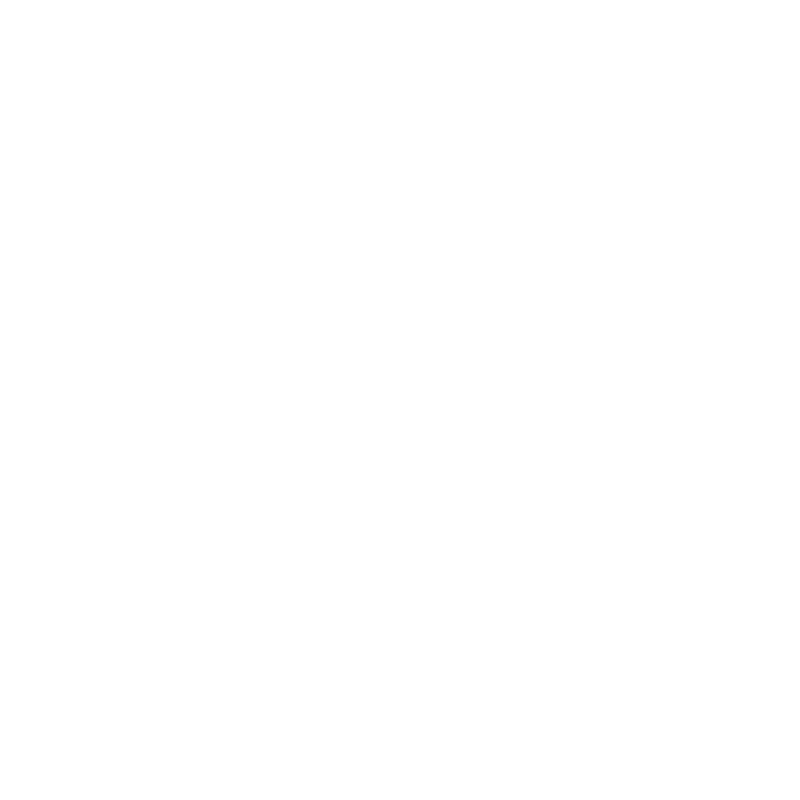

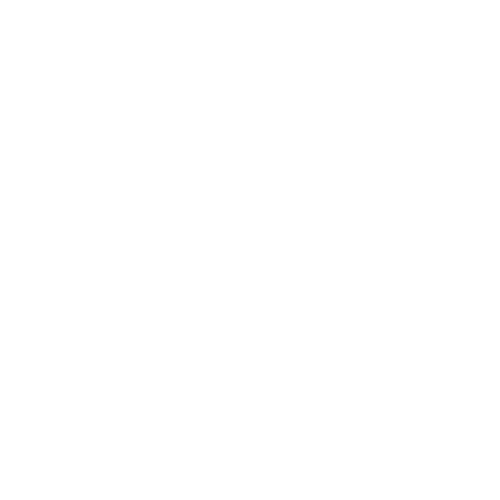

In [76]:
plot_animation(plot_setup, plot_result, result, writer="ffmpeg", codec=None)

## Trying Bloch Sphere Visualization

In [11]:
b = Bloch()
b.add_states(result.states[0])
b.add_states(result.states[4])
print(b.fig)
print(b.axes)
b.render()

None
None


<IPython.core.display.Javascript object>

In [12]:
sphere = Bloch()
sphere.render()
print(sphere.axes, sphere.fig)

def animate(i):
    sphere.clear()
    sphere.add_states(result.states[i])
    sphere.render()
    return sphere.axes

def init():
    sphere.vector_color = ["r"]
    return sphere.axes

# sphere.clear()
# sphere.add_states(result.states[0])
# sphere.render()
ani = animation.FuncAnimation(sphere.fig, animate, len(result.times), init_func=init, blit=False, repeat=False)
writer = animation.PillowWriter(fps=30, bitrate=1800)
ani.save('bloch_sphere2.gif', writer=writer)

<IPython.core.display.Javascript object>

Axes3D(0,0;1x1) Figure(500x500)


IndexError: list index out of range

In [102]:
dir(b)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_arcs',
 '_ext_fig',
 '_is_inline_backend',
 '_lines',
 '_repr_png_',
 '_repr_svg_',
 'add_annotation',
 'add_arc',
 'add_line',
 'add_points',
 'add_states',
 'add_vectors',
 'annotations',
 'axes',
 'background',
 'clear',
 'fig',
 'figsize',
 'font_color',
 'font_size',
 'frame_alpha',
 'frame_color',
 'frame_width',
 'make_sphere',
 'plot_annotations',
 'plot_arcs',
 'plot_axes',
 'plot_axes_labels',
 'plot_back',
 'plot_front',
 'plot_lines',
 'plot_points',
 'plot_vectors',
 'point_alpha',
 'point_color',
 'point_marker',
 'point_size',
 'point_style',
 'points',
 'render',
 'run_from_ipython',
 's

In [110]:
b.render()